## Importing Packages and Dataset

In [1]:
#loading
import pandas as pd
import numpy as np
import missingno as msno
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
!pip install chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
#preprocessing 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
# Classification 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

     |████████████████████████████████| 64 kB 1.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
data = pd.read_csv("../input/air-quality-data-in-india/city_day.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.rename(columns = {'AQI_Bucket':'Air_quality'}, inplace = True)
data.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Air_quality
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   City         29531 non-null  object        
 1   Date         29531 non-null  datetime64[ns]
 2   PM2.5        24933 non-null  float64       
 3   PM10         18391 non-null  float64       
 4   NO           25949 non-null  float64       
 5   NO2          25946 non-null  float64       
 6   NOx          25346 non-null  float64       
 7   NH3          19203 non-null  float64       
 8   CO           27472 non-null  float64       
 9   SO2          25677 non-null  float64       
 10  O3           25509 non-null  float64       
 11  Benzene      23908 non-null  float64       
 12  Toluene      21490 non-null  float64       
 13  Xylene       11422 non-null  float64       
 14  AQI          24850 non-null  float64       
 15  Air_quality  24850 non-null  object        
dtypes: d

## **Exploratory Data Analysis**

**Missing value  analysis and Treatment**

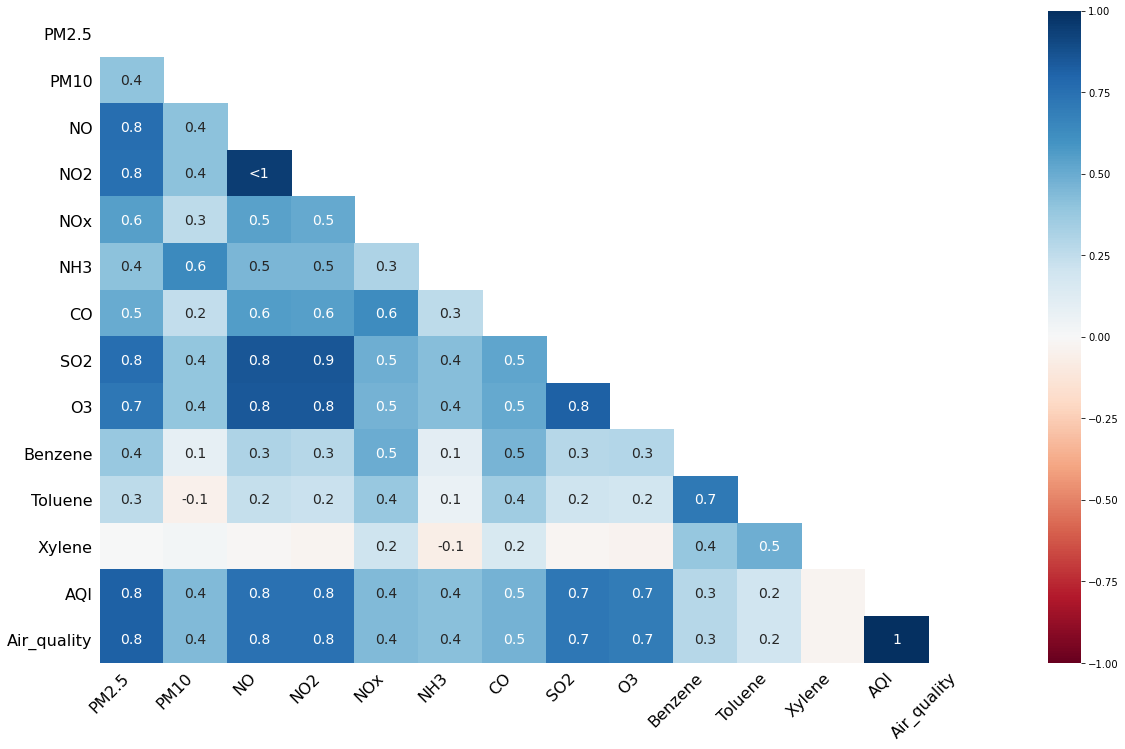

In [4]:
msno.heatmap(data)

In [5]:
df1 = data.copy()
df1['PM2.5']=df1['PM2.5'].fillna((df1['PM2.5'].median()))
df1['PM10']=df1['PM10'].fillna((df1['PM10'].median()))
df1['NO']=df1['NO'].fillna((df1['NO'].median()))
df1['NO2']=df1['NO2'].fillna((df1['NO2'].median()))
df1['NOx']=df1['NOx'].fillna((df1['NOx'].median()))
df1['NH3']=df1['NH3'].fillna((df1['NH3'].median()))
df1['CO']=df1['CO'].fillna((df1['CO'].median()))
df1['SO2']=df1['SO2'].fillna((df1['SO2'].median()))
df1['O3']=df1['O3'].fillna((df1['O3'].median()))
df1['Benzene']=df1['Benzene'].fillna((df1['Benzene'].median()))
df1['Toluene']=df1['Toluene'].fillna((df1['Toluene'].median()))
df1['Xylene']=df1['Xylene'].fillna((df1['Xylene'].median()))
df1['AQI']=df1['AQI'].fillna((df1['AQI'].median()))
df1['Air_quality']=df1['Air_quality'].fillna('Moderate')

## Pre Corona [2016 to 2020]

**Here I divide the data set into two part namely Vehicular Pollution content (PM2.5, PM10, NO2, NH3, CO,) and Industrial Pollution content (CO, SO2, O3, Benzene, Toluene, Xylene) and find how these contents correlated with AQI (air quality index)**

In [6]:
df = df1.copy()
df = df[df['Date'] <= ('01-01-2020')] 
df['Vehicular Pollution content'] = df['PM2.5']+df['PM10']+df['NO']+df['NO2']+df['NOx']+df['NH3']+df['CO']
df['Industrial Pollution content'] = df['SO2']+df['O3']+df['Benzene']+df['Toluene']+df['Xylene']
df = df.drop(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3','Benzene','Toluene','Xylene'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24908 entries, 0 to 29348
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   City                          24908 non-null  object        
 1   Date                          24908 non-null  datetime64[ns]
 2   AQI                           24908 non-null  float64       
 3   Air_quality                   24908 non-null  object        
 4   Vehicular Pollution content   24908 non-null  float64       
 5   Industrial Pollution content  24908 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.3+ MB


In [7]:
def ploting(var):
    df[var].iplot(title=var,xTitle='Cities',yTitle=var, linecolor='black', )
    plt.show()
ploting('Vehicular Pollution content')
ploting('Industrial Pollution content')

In [8]:
def max_bar_plot(var):
    x1 = df[['City',var]].groupby(["City"]).median().sort_values(by = var,
    ascending = True).tail(10).iplot(kind='bar', xTitle='Cities',yTitle=var, 
                                     linecolor='black', title='{2} {1} {0}'.format(")",var,' Most polluted cities('))

p1 = max_bar_plot('Industrial Pollution content')
p2 = max_bar_plot('Vehicular Pollution content')

In [9]:
def min_bar_plot(var):
    x1 = df[['City',var]].groupby(["City"]).mean().sort_values(by = var,
    ascending = True).head(10).iplot(kind='bar', yTitle='Cities',xTitle=var, linecolor='black',title='{2} {1} {0}'.format(")",var,' Minimum polluted cities('))
p1 = min_bar_plot('Industrial Pollution content')
p2 = min_bar_plot('Vehicular Pollution content')

In [10]:
def al(var):
    cities = [var]
    filtered_city_day = df1[df1['Date'] <= '2020-04-01']
    AQI = filtered_city_day[filtered_city_day.City.isin(cities)][['City','Air_quality']]
    AQI[var] = AQI['Air_quality']
    k = AQI[var].value_counts()
    m = pd.DataFrame((round((k/sum(k))*100)))
    return m
c11 = al('Ahmedabad')
c22 = al('Delhi')
c33 = al('Kolkata')
c44 = al('Mumbai')
c55 = al('Bengaluru')
df_row = pd.concat([c11,c22,c33,c44,c55],axis=1)
df_row.iplot(kind='bar', align='center',xTitle='Satisfaction level', yTitle='percentage of satisfaction' ,linecolor='black', title='Satisfaction level of people(Pre COVID19)')

## Post Corona [2020 >]

In [11]:
df = df1.copy()
df = df[df['Date'] > ('01-01-2020')] 
df['Vehicular Pollution content'] = df['PM2.5']+df['PM10']+df['NO']+df['NO2']+df['NOx']+df['NH3']+df['CO']
df['Industrial Pollution content'] = df['SO2']+df['O3']+df['Benzene']+df['Toluene']+df['Xylene']
df = df.drop(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3','Benzene','Toluene','Xylene'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4623 entries, 1827 to 29530
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   City                          4623 non-null   object        
 1   Date                          4623 non-null   datetime64[ns]
 2   AQI                           4623 non-null   float64       
 3   Air_quality                   4623 non-null   object        
 4   Vehicular Pollution content   4623 non-null   float64       
 5   Industrial Pollution content  4623 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 252.8+ KB


In [12]:
def ploting(var):
    df[var].iplot(title=var,xTitle='Cities',yTitle=var, linecolor='black', )
    plt.show()
ploting('Vehicular Pollution content')
ploting('Industrial Pollution content')

In [13]:
def max_bar_plot(var):
    x1 = df[['City',var]].groupby(["City"]).median().sort_values(by = var,
    ascending = True).tail(10).iplot(kind='bar', xTitle='Cities',yTitle=var, 
                                     linecolor='black', title='{2} {1} {0}'.format(")",var,' Most polluted cities('))

p1 = max_bar_plot('Industrial Pollution content')
p2 = max_bar_plot('Vehicular Pollution content')

In [14]:
def min_bar_plot(var):
    x1 = df[['City',var]].groupby(["City"]).mean().sort_values(by = var,
    ascending = True).head(10).iplot(kind='bar', yTitle='Cities',xTitle=var, linecolor='black',title='{2} {1} {0}'.format(")",var,' Minimum polluted cities('))
p1 = min_bar_plot('Industrial Pollution content')
p2 = min_bar_plot('Vehicular Pollution content')

In [15]:
def al(var):
    cities = [var]
    filtered_city_day = df1[df1['Date'] > '2020-04-01']
    AQI = filtered_city_day[filtered_city_day.City.isin(cities)][['City','Air_quality']]
    AQI[var] = AQI['Air_quality']
    k = AQI[var].value_counts()
    m = pd.DataFrame((round((k/sum(k))*100)))
    return m
c11 = al('Ahmedabad')
c22 = al('Delhi')
c33 = al('Kolkata')
c44 = al('Mumbai')
c55 = al('Bengaluru')
df_row = pd.concat([c11,c22,c33,c44,c55],axis=1)
df_row.iplot(kind='bar', align='center',xTitle='Satisfaction level', yTitle='percentage of satisfaction' ,linecolor='black', title='Satisfaction level of people(Post COVID19)')

## Preprocessing

In [16]:
categorical_attributes = list(df1.select_dtypes(include=['object']).columns)
print("categorical_attributes",categorical_attributes)
le=LabelEncoder()
df1['City']=le.fit_transform(df1['City'].astype(str))
df1['Air_quality']=le.fit_transform(df1['Air_quality'].astype(str))
df1.info()

categorical_attributes ['City', 'Air_quality']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   City         29531 non-null  int64         
 1   Date         29531 non-null  datetime64[ns]
 2   PM2.5        29531 non-null  float64       
 3   PM10         29531 non-null  float64       
 4   NO           29531 non-null  float64       
 5   NO2          29531 non-null  float64       
 6   NOx          29531 non-null  float64       
 7   NH3          29531 non-null  float64       
 8   CO           29531 non-null  float64       
 9   SO2          29531 non-null  float64       
 10  O3           29531 non-null  float64       
 11  Benzene      29531 non-null  float64       
 12  Toluene      29531 non-null  float64       
 13  Xylene       29531 non-null  float64       
 14  AQI          29531 non-null  float64       
 15  Air_qu

In [17]:
cor = df1.corr()
cor.style.background_gradient(cmap='coolwarm')

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Air_quality
City,1.000000,0.062446,-0.021395,0.047182,-0.078589,0.024948,-0.182565,-0.255886,-0.101327,0.001530,0.002070,-0.062730,-0.047806,-0.121778,-0.053770
PM2.5,0.062446,1.000000,0.520767,0.435245,0.358287,0.375938,0.164615,0.093695,0.120451,0.166064,0.030539,0.132609,0.087813,0.633654,0.408614
PM10,-0.021395,0.520767,1.000000,0.433864,0.352396,0.416523,0.200548,0.023932,0.165468,0.208398,0.027522,0.126400,0.030257,0.447686,0.208080
NO,0.047182,0.435245,0.433864,1.000000,0.465848,0.747409,0.155804,0.221445,0.174881,0.020788,0.045202,0.151930,0.084393,0.438039,0.259407
NO2,-0.078589,0.358287,0.352396,0.465848,1.000000,0.581938,0.151731,0.361750,0.388413,0.289435,0.042179,0.297913,0.188965,0.531952,0.259199
NOx,0.024948,0.375938,0.416523,0.747409,0.581938,1.000000,0.129433,0.231878,0.205912,0.089095,0.049004,0.184764,0.085447,0.436282,0.212592
NH3,-0.182565,0.164615,0.200548,0.155804,0.151731,0.129433,1.000000,-0.014252,-0.048679,0.076295,0.004093,0.020040,-0.030328,0.097916,0.077250
CO,-0.255886,0.093695,0.023932,0.221445,0.361750,0.231878,-0.014252,1.000000,0.476784,0.043311,0.066022,0.285559,0.181215,0.650475,0.215848
SO2,-0.101327,0.120451,0.165468,0.174881,0.388413,0.205912,-0.048679,0.476784,1.000000,0.160489,0.038955,0.273314,0.249808,0.454182,0.170843
O3,0.001530,0.166064,0.208398,0.020788,0.289435,0.089095,0.076295,0.043311,0.160489,1.000000,0.023982,0.135498,0.084323,0.199100,0.030637


In [18]:
y = df1["Air_quality"]
x = df1[['City', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [19]:
print('Classes and number of values in trainset',Counter(y_train))

Classes and number of values in trainset Counter({1: 9393, 3: 5799, 2: 1940, 5: 1634, 4: 957, 0: 948})


> **Data Imbalance:**

>  Here we observe that target label is not splitted eqaully. This will cause data imbalance problem. In order to overcome this problem we use the technique called SMOTE(Synthetic Minority Oversampling Technique). This approach solve this problem by oversample the examples in the minority class.

In [20]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train,y_train = oversample.fit_resample(X_train,y_train)
print('Classes and number of values in trainset after SMOTE:',Counter(y_train))

Classes and number of values in trainset after SMOTE: Counter({1: 9393, 5: 9393, 3: 9393, 0: 9393, 2: 9393, 4: 9393})


## Classification

### 1. Support Vector Machine

In [21]:
cls=SVC()
cls.fit(X_train,y_train)
svmpred=cls.predict(X_test)
svmpred
cm=confusion_matrix(y_test,svmpred)
print("confussion matrix")
print(cm)
print("\n")
accuracy=accuracy_score(y_test,svmpred)
print("accuracy",accuracy*100)

confussion matrix
[[ 393    0    0    0    0    0]
 [   0 3937   80  100    0    0]
 [   0    0  824    0    0   17]
 [ 128    1    0 2296    0    0]
 [   0    0    0    0  378    3]
 [   0    0    1    0   11  691]]


accuracy 96.15124153498871


### 2. Random Forest

In [22]:
rf = RandomForestClassifier(n_estimators=20, random_state=23)
rf.fit(X_train, y_train)
rf_predict=rf.predict(X_test)
rf_predict1=rf.predict(X_train)
rf_conf_matrix = confusion_matrix(y_test, rf_predict)
rf_acc_score = accuracy_score(y_test, rf_predict)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("accuracy",rf_acc_score*100)

confussion matrix
[[ 393    0    0    0    0    0]
 [   0 4116    1    0    0    0]
 [   0    2  839    0    0    0]
 [   0    1    0 2424    0    0]
 [   0    0    1    0  378    2]
 [   0    0    1    0    1  701]]


accuracy 99.89841986455981


### 3. XGBoost

In [23]:
gbc=XGBClassifier(learning_rate =0.01,n_estimators=100,max_depth=1,
                  min_child_weight=6,subsample=0.8,seed=13)
gbc.fit(X_train,y_train)
pred = gbc.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, pred)
accuracy = accuracy_score(y_test, pred)*100
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("accuracy",accuracy)

confussion matrix
[[ 393    0    0    0    0    0]
 [   0 4117    0    0    0    0]
 [   0    0  841    0    0    0]
 [   0    0    0 2425    0    0]
 [   0    0    0    0  381    0]
 [   0    0    0    0    0  703]]


accuracy 100.0


## Conclusion

>1. Vehicular pollution contents are more related to air quality index.
>2. Delhi is the most polluted city in terms of vehicular pollution contents.
>3. Ahmadabad is the most polluted city in terms of industrial pollution content.
>4. After COVID19 pandemic there is gradual dicrease in vehicular pollution contents, industrial pollution content.
>5. Extra Gradient Boost classifier 100% accurately classify the target variable.